# **1. Load Data**

In [ ]:
from scipy.io import loadmat
data = loadmat('/content/data1.mat')

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'TrainingX', 'TrainingY', 'TestX', 'TestY'])

In [ ]:
X = data['TrainingX']
y = data['TrainingY']
X_test = data['TestX']
y_test = data['TestY']
N = len(X)
N_test = len(X_test)

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda')

In [ ]:
X_t = torch.from_numpy(X).to(device)
y_t = torch.from_numpy(y).to(device)
X_t_test = torch.from_numpy(X_test).to(device)
y_t_test = torch.from_numpy(y_test).to(device)

# **2. Define Gradient**

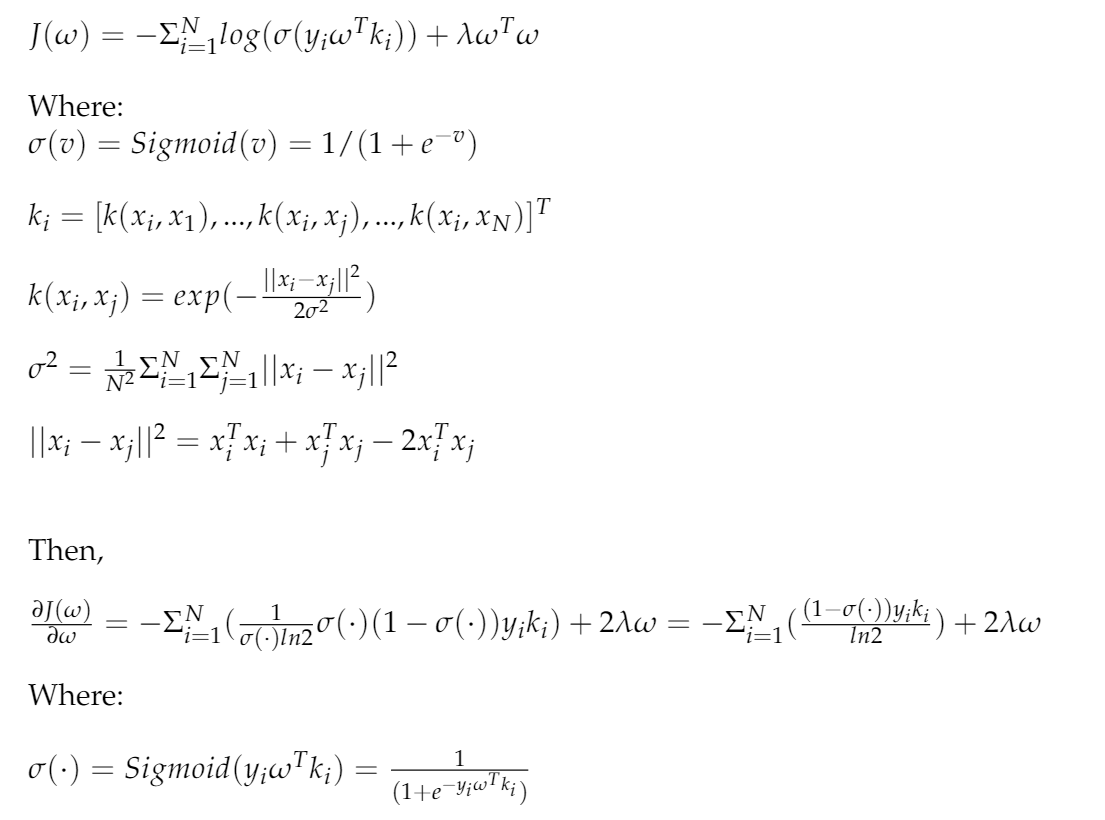

In [ ]:
from IPython.display import Image
Image('/content/20210413202456.png')

**The training set has 10000 samples while the test test has 1000 samples.**

**From J(w), we know that the w must have same elemnts as k.**

**Therefore, the model trained on the training set cannot be applyed to the test set.**



In [ ]:
import numpy as np
shuffle = np.arange(10000)
np.random.shuffle(shuffle)
X_shuffle = X[shuffle]
y_shuffle = y[shuffle]

In [ ]:
X_t_shuffle = torch.from_numpy(X_shuffle).to(device)
y_t_shuffle = torch.from_numpy(y_shuffle).to(device)

In [ ]:
X_mini_batch = []
y_mini_batch = []
for i in range(10):
  X_mini_batch.append(X_t_shuffle[1000*i:1000+1000*i])
  y_mini_batch.append(y_t_shuffle[1000*i:1000+1000*i])

### **Compute sigma used in RBF kernel**

In [ ]:
# train set sigma
X_dist = torch.cdist(X_t,X_t, p=1)
sigma2 = torch.sum(torch.sum(X_dist))/(N**2)
sigma2

tensor(129.4998, device='cuda:0', dtype=torch.float64)

In [ ]:
# test set sigma
X_test_dist = torch.cdist(X_t_test,X_t_test, p=1)
sigma2_test = torch.sum(torch.sum(X_test_dist))/(N_test**2)
sigma2_test

tensor(128.6313, device='cuda:0', dtype=torch.float64)

### **Generate kernel map**

In [ ]:
# torch.exp(-torch.norm(X_t[i]-X_t[j])/(2*sigma2))   -->   k(Xi,Xj)

In [ ]:
# for one Xj, Transform to Kmap
def kernel(X_t,X_t_j,sigma2):
  return torch.exp(-torch.norm(X_t-X_t_j,dim=1,p=1)/(2*sigma2)).T

In [ ]:
# build complete empirical kernel map
def kMap(X,sigma2):
  res = []
  for Xi in X:
    res.append(kernel(X,Xi,sigma2))
  return res

KX = kMap(X_t_shuffle,sigma2_test)
# for i in range(10):
#   KX.append(torch.stack(kMap(X_mini_batch[i],sigma2)))
KX = torch.stack(KX).to(device)

KX_test = kMap(X_t_test,sigma2_test)
KX_test = torch.stack(KX_test).to(device)

# **3. Standard model form sklearn.linear_model.LogisticRegression (used for comparasion, mean acc is 93.2%)**

In [ ]:
from sklearn.linear_model import LogisticRegression

standard_model = LogisticRegression(random_state=0).fit(X, y.reshape(10000))
standard_model.score(X, y.reshape(10000))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9399

# **4. Gradient Descent**

### **Compute Gradient**

In [ ]:
# Gradient for one output
def oneGradient(y,w,k):
  A = torch.multiply(y,torch.dot(w.T,k))
  B = torch.multiply(y,k)
  return -torch.multiply((1-torch.sigmoid(A)),B)

In [ ]:
# Total Gradient 1
def Gradient1(X,y,w,lam):
  res = oneGradient(y[0],w,X[0])
  for i in range(1,len(X)):
    res += oneGradient(y[i],w,X[i])
  res = torch.add(res,2*torch.multiply(lam,w))
  return res

In [ ]:
# Total Gradient 2(much faster)
def Gradient2(X,y,w,lam):
  A = torch.multiply(y,torch.mm(w.reshape(1,len(X)),X))
  B = torch.multiply(y,X)
  res = torch.sum(-torch.multiply((1-torch.sigmoid(A)),B),0)
  #res /= len(X)
  res = torch.add(res,2*torch.multiply(lam,w))
  return res

### **Define loss function**

In [ ]:
def Loss(X,y,w,lam):
  res = torch.sum(-torch.log(torch.sigmoid(torch.multiply(y.T,torch.mm(w.reshape(1,len(X)),X)))))
  res /= len(X)
  res = torch.add(res,torch.multiply(lam,torch.dot(w.T,w)))
  return res

In [ ]:
-torch.log(torch.sigmoid(torch.tensor(1)))

tensor(0.3133)

**Through this loss function, the minimum loss for every point is 0.3133, for a batch with 1000 points, even the best predictor will have 313 loss.**

**There for I change the first item with dividing it by N.**

### **Define acc evaluation**

In [ ]:
def predict(w,X):
  res = torch.sigmoid(torch.dot(w.T,X)).item()
  return 1 if res>0.5 else -1

In [ ]:
def eval(X,y,w):
  correct = 0
  for i in range(len(X)):
    if predict(w,X[i])==y[i]:
      correct += 1
  print("acc is: " + str(correct*100.0/len(X)) + "%")

### **Initialize weight**

In [ ]:
import numpy as np
def initial_weight(N):
  mu = 0
  sig = 0.001
  w = torch.from_numpy(np.random.normal(mu, sig, N).T).to(device)
  return w

w = initial_weight(10000)

**the acc of initialized weight will be approximately 50%**

In [ ]:
eval(KX,y_t,w)

acc is: 49.36%


In [ ]:
def train_GD(X,y,X_test,y_test,w,i,lam,ep,lr):
  e = 1
  total_iter = 0
  while e > ep and total_iter < 10000:
    for j in range(1):
      g = Gradient2(X,y,w,lam)
      g = torch.divide(g,(total_iter+1)**0.5)
      w = torch.subtract(w,torch.multiply(lr,g))
      e = torch.median((abs(g)))
    total_iter += 1
    loss_his_GD[i].append(Loss(X,y,w,lam))
    if total_iter%1000 == 0:
      print("iter: " + str(total_iter) + 
            "    gradient median: " + str(e.item()) +
            "    loss: " + str(loss_his_GD[i][-1].item())
            )
      eval(X,y,w)
  eval(X,y,w)
  return w

In [ ]:
lrs = [torch.tensor(0.1/(10**i)) for i in range(10)]
lam = torch.tensor(1e-3)
ep = torch.tensor(0.000001)
loss_his_GD = [[] for i in range(10)]
w_trained_GD = []
w = initial_weight(10000)

In [ ]:
%%time
for i in range(0,10):
  loss_his_GD[i] = []
  print("lr = " + str(lrs[i]) + " :")
  w = initial_weight(10000)
  w_trained_GD.append(train_GD(KX,y_t_shuffle,KX_test,y_t_test,w,i,lam,ep,lrs[i]))

lr = tensor(0.1000) :
iter: 1000    gradient median: 95.47423077371636    loss: inf
acc is: 52.44%
iter: 2000    gradient median: 67.50695524127549    loss: inf
acc is: 50.0%
iter: 3000    gradient median: 55.10480138332136    loss: inf
acc is: 50.0%
iter: 4000    gradient median: 47.74254336125581    loss: inf
acc is: 50.0%
iter: 5000    gradient median: 42.7030083179386    loss: inf
acc is: 50.0%
iter: 6000    gradient median: 38.97815329325341    loss: inf
acc is: 50.0%
iter: 7000    gradient median: 36.08807017983885    loss: inf
acc is: 50.27%
iter: 8000    gradient median: 33.756123472099524    loss: inf
acc is: 65.45%
iter: 9000    gradient median: 31.826372068630548    loss: inf
acc is: 55.91%
iter: 10000    gradient median: 30.193017422542834    loss: inf
acc is: 50.0%
acc is: 50.0%
lr = tensor(0.0100) :
iter: 1000    gradient median: 95.45796107129318    loss: inf
acc is: 52.45%
iter: 2000    gradient median: 67.35471431776277    loss: inf
acc is: 50.0%
iter: 3000    gradient

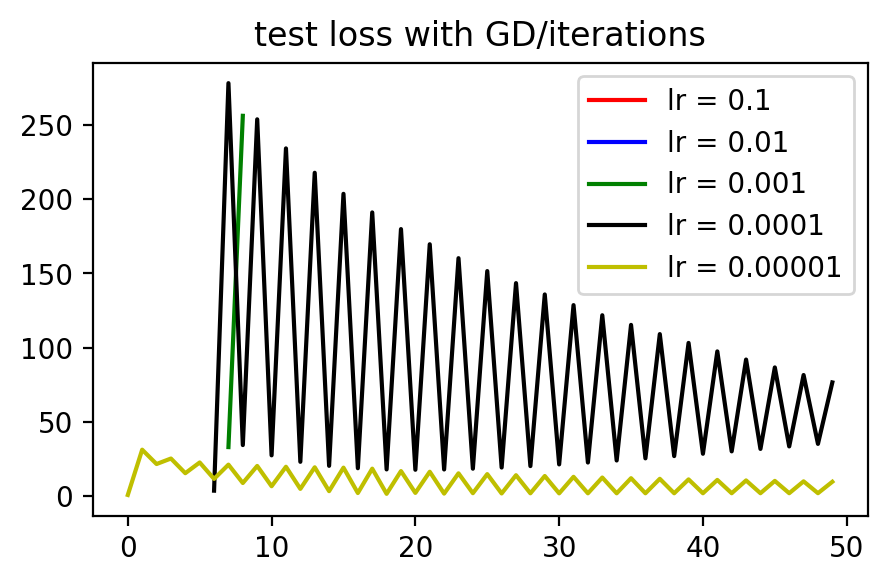

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with GD/iterations')
plt.plot(loss_his_GD[0][0:50], 'r', label='lr = 0.1')
plt.plot(loss_his_GD[1][0:50], 'b', label='lr = 0.01')
plt.plot(loss_his_GD[2][0:50], 'g', label='lr = 0.001')
plt.plot(loss_his_GD[3][0:50], 'k', label='lr = 0.0001')
plt.plot(loss_his_GD[4][0:50], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

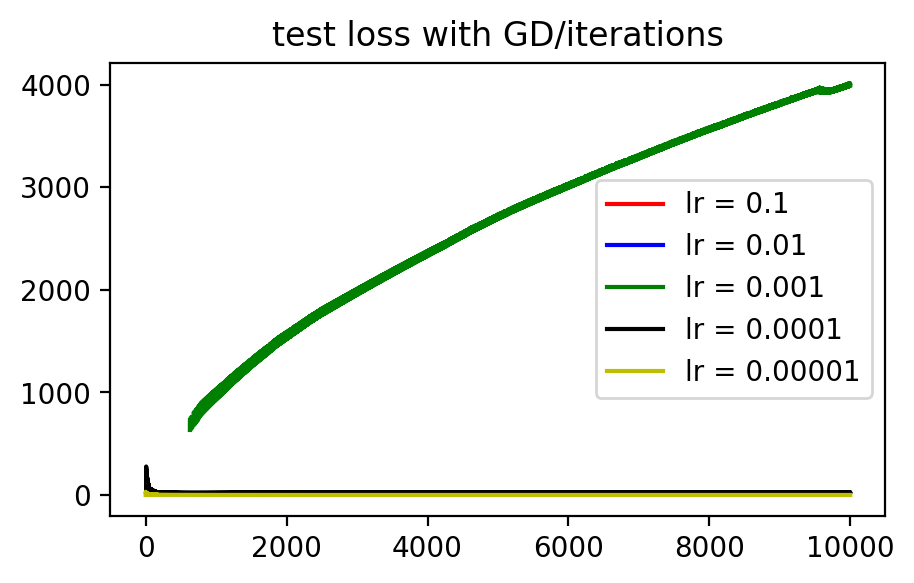

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with GD/iterations')
plt.plot(loss_his_GD[0], 'r', label='lr = 0.1')
plt.plot(loss_his_GD[1], 'b', label='lr = 0.01')
plt.plot(loss_his_GD[2], 'g', label='lr = 0.001')
plt.plot(loss_his_GD[3], 'k', label='lr = 0.0001')
plt.plot(loss_his_GD[4], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

**Gradient descent perform better on learning rate from 1e-5 to 1e-7**

**With too large learning rate, as shown above in the test loss, the loss is fluctuating and and not descent to the right place.**

**With too small learning rate, it's even impossible for the weight to change or it might be trapped in a false  minima.**

In [ ]:
for i,w_final in enumerate(w_trained_GD):
  print('with lr = ', str(lrs[i]) + ':')
  eval(KX,y_t_shuffle,w_final)

with lr =  tensor(0.1000):
acc is: 50.0%
with lr =  tensor(0.0100):
acc is: 50.0%
with lr =  tensor(0.0010):
acc is: 50.0%
with lr =  tensor(1.0000e-04):
acc is: 50.0%
with lr =  tensor(1.0000e-05):
acc is: 86.21%
with lr =  tensor(1.0000e-06):
acc is: 86.24%
with lr =  tensor(1.0000e-07):
acc is: 85.93%
with lr =  tensor(1.0000e-08):
acc is: 76.68%
with lr =  tensor(1.0000e-09):
acc is: 50.0%
with lr =  tensor(1.0000e-10):
acc is: 50.0%


# **5. SGD**

In [ ]:
# S Gradient
def S_Gradient(X,y,w,lam,case):
  res = oneGradient(y[0],w,X[0])
  for i in case:
    res = torch.add(res,oneGradient(y[i],w,X[i]))
  res = torch.add(res,torch.multiply(torch.tensor(2),torch.multiply(lam,w)))
  return res

In [ ]:
def train_SGD(X,y,X_test,y_test,w,i,lam,ep,p):
  e = 1
  lr = lrs[i]
  total_iter = 0
  A = np.arange(10000)
  while e > ep and total_iter < 100000:
    np.random.shuffle(A)
    case = A[0:p]
    g = S_Gradient(X,y,w,lam,case)           #use one_gradient to randomly select gradient, much slower
    g = torch.divide(g,(total_iter+1)**0.5)
    w = torch.subtract(w,torch.multiply(lr,g))
    e = torch.median((abs(g)))
    total_iter += 1
    
    loss_his_SGD[i].append(Loss(X,y,w,lam))
    if total_iter%1000 == 0:
      print()
      print("iter: " + str(total_iter) + "    gradient median: " + str(e.item()) +"    loss: " + str(loss_his_SGD[i][-1].item()))
      eval(X,y,w)
  eval(X,y,w)
  return w

In [ ]:
%%time
loss_his_SGD = [[] for i in range(10)]
w_trained_SGD = []
w = initial_weight(10000)


#p = 1
#print("p = " + str(p))
#for i in range(5):
#  print("lr = " + str(lrs[i]) + " :")
#  w = initial_weight(10000)
#  w_trained_SGD.append(train_SGD(KX,y_t_shuffle,KX_test,y_t_test,w,i,lam,ep,p))

p = 100
for i in range(5):
  print("lr = " + str(lrs[i]) + " :")
  w = initial_weight(10000)
  w_trained_SGD.append(train_SGD(KX,y_t_shuffle,KX_test,y_t_test,w,i+5,lam,ep,p))

lr = tensor(0.1000) :

iter: 1000    gradient median: 0.026256156744034573    loss: 0.6860346210114119
acc is: 54.38%

iter: 2000    gradient median: 0.024494364244240372    loss: 0.6837803231201254
acc is: 52.51%

iter: 3000    gradient median: 0.12799752510208107    loss: 0.6820210308876197
acc is: 58.42%

iter: 4000    gradient median: 0.030730325109083592    loss: 0.6806520023520354
acc is: 52.83%

iter: 5000    gradient median: 0.09429978231968719    loss: 0.6792839145382559
acc is: 61.29%

iter: 6000    gradient median: 0.03284780357225888    loss: 0.678081103747143
acc is: 68.46%

iter: 7000    gradient median: 0.011033910309924089    loss: 0.677043237130726
acc is: 67.06%

iter: 8000    gradient median: 0.015628509819557514    loss: 0.676098555739067
acc is: 65.07%

iter: 9000    gradient median: 0.03954726859633001    loss: 0.6751412773688495
acc is: 69.82%

iter: 10000    gradient median: 0.007893429851144806    loss: 0.6742479839849017
acc is: 74.82%

iter: 11000    gradient

KeyboardInterrupt: ignored

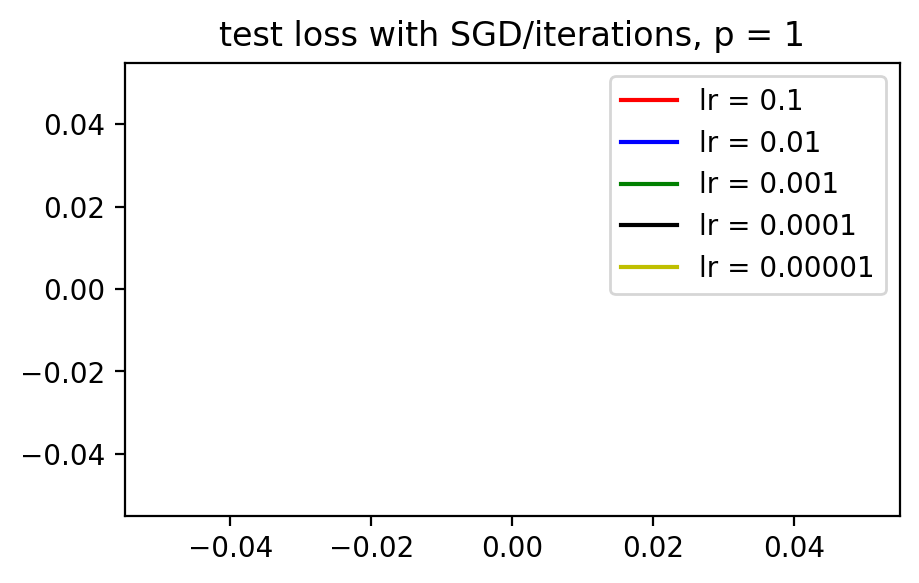

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with SGD/iterations, p = 1')
plt.plot(loss_his_SGD[0][0:50], 'r', label='lr = 0.1')
plt.plot(loss_his_SGD[1][0:50], 'b', label='lr = 0.01')
plt.plot(loss_his_SGD[2][0:50], 'g', label='lr = 0.001')
plt.plot(loss_his_SGD[3][0:50], 'k', label='lr = 0.0001')
plt.plot(loss_his_SGD[4][0:50], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

**Noticed that with p = 1, the sample size is too small for the function to descent in a right way.**

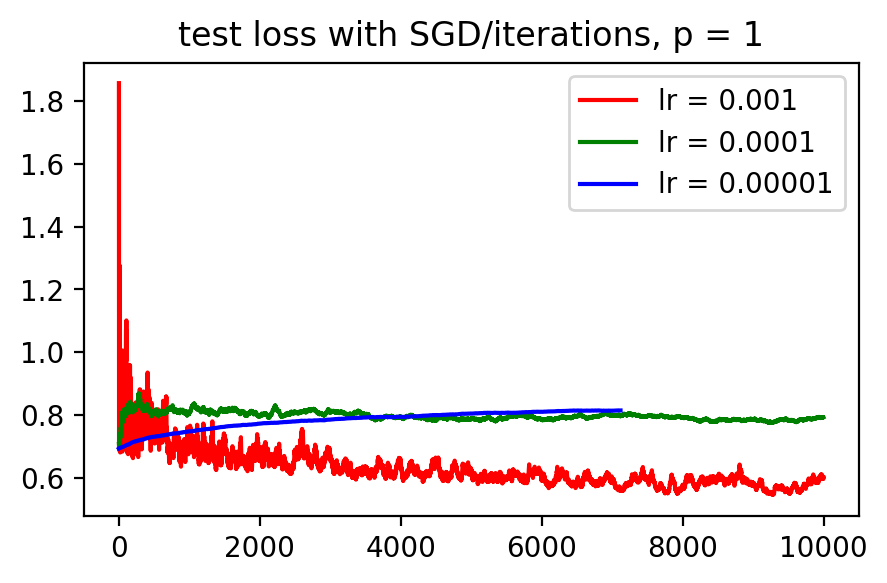

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with SGD/iterations, p = 1')
plt.plot(loss_his_SGD[2][0:10000], 'r', label='lr = 0.001')
plt.plot(loss_his_SGD[3][0:10000], 'g', label='lr = 0.0001')
plt.plot(loss_his_SGD[4][0:10000], 'b', label='lr = 0.00001')
plt.legend()
plt.show()

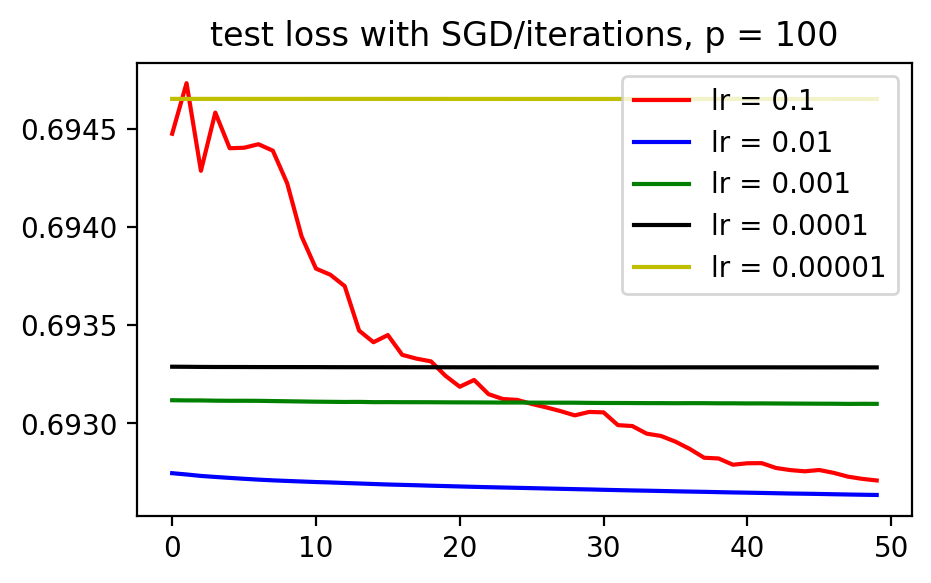

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with SGD/iterations, p = 100')
plt.plot(loss_his_SGD[5][0:50], 'r', label='lr = 0.1')
plt.plot(loss_his_SGD[6][0:50], 'b', label='lr = 0.01')
plt.plot(loss_his_SGD[7][0:50], 'g', label='lr = 0.001')
plt.plot(loss_his_SGD[8][0:50], 'k', label='lr = 0.0001')
plt.plot(loss_his_SGD[9][0:50], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

**With SGD and p=100, it performs much better than the normal GD, even with very large learning rate, it can manage to get the right weight.**

**With SGD, only looks at part of the gradient, the training is much faster than the normal GD which takes every point into consideration**

In [ ]:
for i,w_final in enumerate(w_trained_SGD):
  if i < 5:
    print('with p = 1 and lr = ', str(lrs[i]) + ':')
    eval(KX,y_t_shuffle,w_final)
  else:
    if i == 5:
      print()
    print('with p = 100 and lr = ', str(lrs[i-5]) + ':')
    eval(KX,y_t_shuffle,w_final)

with p = 1 and lr =  tensor(0.1000):
acc is: 50.0%
with p = 1 and lr =  tensor(0.0100):
acc is: 50.0%
with p = 1 and lr =  tensor(0.0010):
acc is: 57.25%
with p = 1 and lr =  tensor(1.0000e-04):
acc is: 50.0%
with p = 1 and lr =  tensor(1.0000e-05):
acc is: 50.0%

with p = 100 and lr =  tensor(0.1000):
acc is: 68.11%
with p = 100 and lr =  tensor(0.0100):
acc is: 50.0%
with p = 100 and lr =  tensor(0.0010):
acc is: 56.1%
with p = 100 and lr =  tensor(1.0000e-04):
acc is: 50.0%
with p = 100 and lr =  tensor(1.0000e-05):
acc is: 50.0%


**AS we can see from the loss history, when p=1, the model accurately trained with lr = 1e-3. with small p, it can barely represents the whole data feature.**

**with p = 100, the training goes well with lr = 0.1.(acc is not very high because it only goes 10,000 iterations. when iteration goes to 50000, the accuracy will be around 87%. I lost my data and cannot train it again due to google colab usage limit on GPU)**

# **6. BFGS**

**With BFGS, we need to approximately compute the Hessian Matrix(H), we compute the change of the H instead of directly computing the H.**

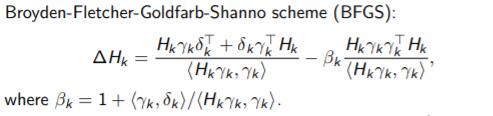

In [ ]:
Image('/content/20210416153204.jpg')

**H is a N*N matrix which initialized as Identity Matriix**

In [ ]:
# initialize
H = torch.eye(1000).to(device)
H

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

**γ is the change of the gradient. J'(w)**

In [ ]:
def gamma(gd_old,gd_new):
  return torch.subtract(gd_new,gd_old)

**δ is the change of the w.**

In [ ]:
def delta(w_old,w_new):
  return torch.subtract(w_new,w_old)

**<·> is the inner-product of the matrix.(torch.sum)**

In [ ]:
# A = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
# B = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
# torch.tensordot(A,B,dims=2)

# A = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
# B = torch.tensor([1,2,3]])
# torch.tensordot(A,B,dims=1)

**Implement BFGS**

In [ ]:
def delta_H_BFGS(H_old,gd_old,gd_new,w_old,w_new):
  Gamma = torch.subtract(gd_new,gd_old)
  Delta = torch.subtract(w_new,w_old)
  #Beta
  Beta = torch.add(torch.tensor(2), 
                   torch.divide(torch.tensordot(Gamma,
                                                Delta,dims=1
                                                ), 
                                torch.tensordot(torch.tensordot(H_old, 
                                                                Gamma,dims=1
                                                                ),
                                                Gamma,dims=1
                                                ) 
                                )
                   )
  # first item
  first = torch.divide(
                      torch.add(
                                torch.mul(
                                          torch.tensordot(H_old, 
                                                          Gamma,dims=1
                                                          ),
                                          Delta.T
                                          ),
                                torch.mul(
                                          torch.mul(Delta, 
                                                    Gamma.T
                                                    ),
                                          H_old
                                          )
                                ),
                      torch.tensordot(
                                      torch.tensordot(H_old, 
                                                      Gamma,dims=1
                                                ),
                                      Gamma,dims=1
                                      )
                      )
  
  # second item
  second = torch.divide(torch.mul(torch.mul(torch.mul(H_old,
                                                      Gamma
                                                      ),
                                            Gamma.T
                                            ),
                                  H_old
                                  ), 
                        torch.tensordot(torch.tensordot(H_old, 
                                                        Gamma,dims=1
                                                        ),
                                        Gamma,dims=1
                                        )
                        )
  
  res = torch.subtract(first, torch.mul(Beta, second))
  return res

**Implement Training with BFGS**

In [ ]:
def train_BFGS(X,y,X_test,y_test,i,w,lam,ep,lr):
  e = 1
  total_iter = 0
  
  while e > ep and total_iter < 10000:
    for j in range(1):
      if total_iter ==0:
        H = torch.eye(len(X),dtype=torch.double).to(device)
        g_old = torch.zeros(len(X)).to(device)
      else:
        g_old = g
      w_old = w
      g = Gradient2(X,y,w,lam)
      g = torch.tensordot(H,g,dims=1)
      g = torch.divide(g,(total_iter+1)**0.5)
      w = torch.subtract(w,torch.multiply(lr,g))
      e = torch.median((abs(g)))

      delta_H = delta_H_BFGS(H,g_old,g,w_old,w)
      H = torch.add(delta_H,H)
      
    total_iter += 1
    loss_his_BFGS[i].append(Loss(X_test,y_test,w,lam))

    if total_iter%1000 == 0:
      print("iter: " + str(total_iter) + 
            "    gradient median: " + str(e.item()) +
            "    loss: " + str(loss_his_BFGS[i][-1].item())
            )
      eval(X,y,w)
  eval(X,y,w)
  return w

**2000 points with label 1, 2000 points with label -1.**

In [ ]:
X_1 = []
X_0 = []
y_1 = []
y_0 = []

shuffle = np.arange(5000)
np.random.shuffle(shuffle)
A = shuffle[0:2000]
for i in A:
  X_1.append(X[i])
  y_1.append(y[i])

shuffle = np.arange(5000)
np.random.shuffle(shuffle)
np.random.shuffle(shuffle)
A = shuffle[0:2000]
for i in A:
  X_0.append(X[5000+i])
  y_0.append(y[5000+i])

X_trans = np.vstack((X_1,X_0))
y_trans = np.vstack((y_1,y_0))

shuffle = np.arange(4000)
np.random.shuffle(shuffle)
X_trans_shuffle = X_trans[shuffle]
y_trans_shuffle = y_trans[shuffle]


X_trans_shuffle = torch.from_numpy(X_trans_shuffle).to(device)
y_trans_shuffle = torch.from_numpy(y_trans_shuffle).to(device)

X_trans_dist = torch.cdist(X_trans_shuffle,X_trans_shuffle, p=1)
sigma2_trans = torch.sum(torch.sum(X_trans_dist))/(N**2)

KX_trans = kMap(X_trans_shuffle,sigma2_trans)
KX_trans = torch.stack(KX_trans).to(device)

**inital acc is aronud 50%**

In [ ]:
w = initial_weight(4000)
eval(KX_trans,y_trans_shuffle,w)

acc is: 50.9%


**training**

In [ ]:
%%time
loss_his_BFGS = [[] for i in range(10)]
w_trained_BFGS = []
w = initial_weight(4000)

for i in range(0,10):
  print("lr = " + str(lrs[i]) + " :")
  w = initial_weight(4000)
  w_trained_BFGS.append(train_BFGS(KX_trans,y_trans_shuffle,KX_trans,y_trans_shuffle,i,w,lam,ep,lrs[i]))


lr = tensor(0.1000) :
iter: 1000    gradient median: 66.19830994554731    loss: inf
acc is: 85.95%
iter: 2000    gradient median: 17.7278713160974    loss: 393.88519308869667
acc is: 50.0%
iter: 3000    gradient median: 43.70290910095737    loss: inf
acc is: 50.0%
iter: 4000    gradient median: 1.5571054852851285    loss: 268.4704045975046
acc is: 87.6%
iter: 5000    gradient median: 8.575688785673353    loss: 354.07112717219604
acc is: 54.0%
iter: 6000    gradient median: 27.61962431822941    loss: 377.15841990591264
acc is: 70.475%
iter: 7000    gradient median: 27.67225533925245    loss: 399.17787932939757
acc is: 88.85%
iter: 8000    gradient median: 23.009868195649616    loss: inf
acc is: 50.0%
iter: 9000    gradient median: 24.274359002814965    loss: inf
acc is: 50.0%
iter: 10000    gradient median: 33.851635120499274    loss: 617.3256827155703
acc is: 50.5%
acc is: 50.5%
lr = tensor(0.0100) :
iter: 1000    gradient median: 9.252668367505066    loss: 10.889553385692498
acc is: 5

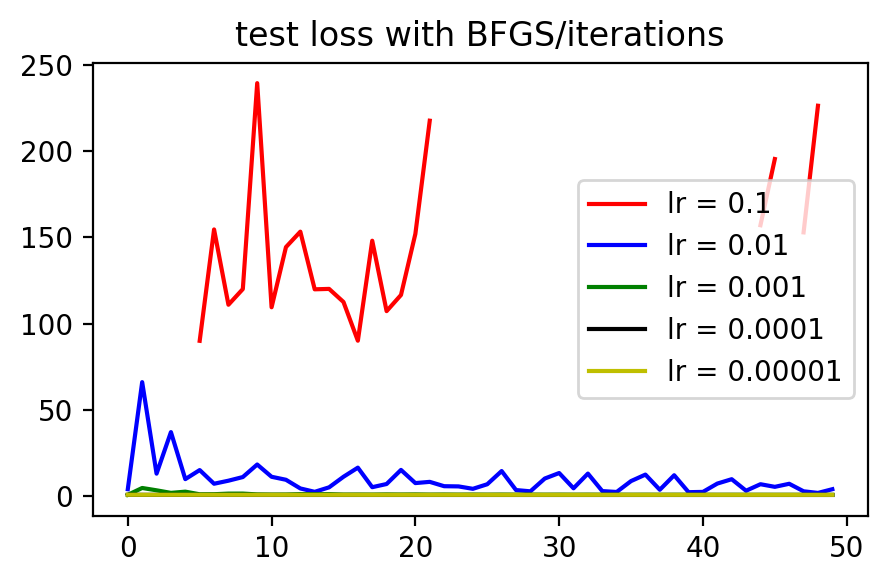

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with BFGS/iterations')
plt.plot(loss_his_BFGS[0][0:50], 'r', label='lr = 0.1')
plt.plot(loss_his_BFGS[1][0:50], 'b', label='lr = 0.01')
plt.plot(loss_his_BFGS[2][0:50], 'g', label='lr = 0.001')
plt.plot(loss_his_BFGS[3][0:50], 'k', label='lr = 0.0001')
plt.plot(loss_his_BFGS[4][0:50], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

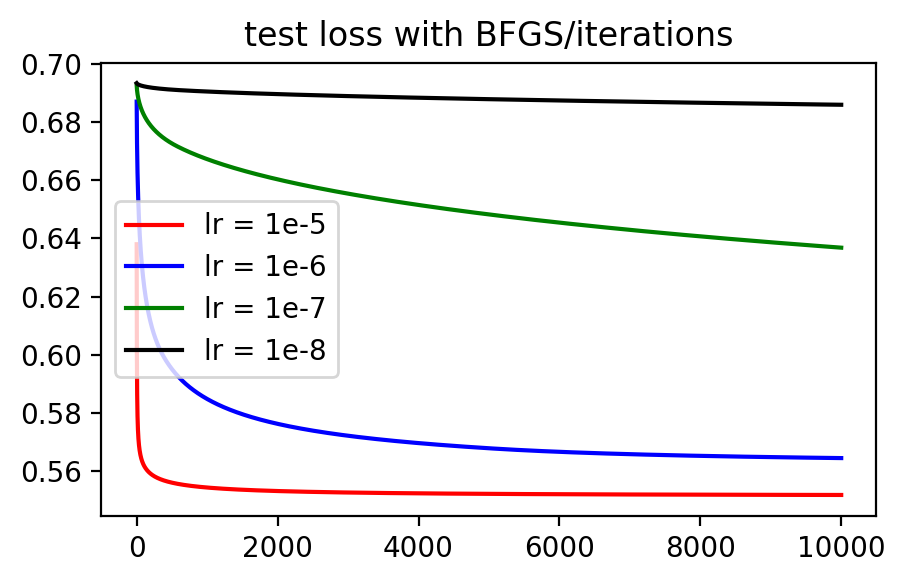

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with BFGS/iterations')
plt.plot(loss_his_BFGS[3], 'r', label='lr = 1e-5')
plt.plot(loss_his_BFGS[4], 'b', label='lr = 1e-6')
plt.plot(loss_his_BFGS[5], 'g', label='lr = 1e-7')
plt.plot(loss_his_BFGS[6], 'k', label='lr = 1e-8')
plt.legend()
plt.show()

In [ ]:
for i in range(10):
  print('with learning rate = ' + str(lrs[i]) + ":")
  eval(KX_trans,y_trans_shuffle,w_trained_BFGS[i])

with learning rate = tensor(0.1000):
acc is: 50.5%
with learning rate = tensor(0.0100):
acc is: 79.4%
with learning rate = tensor(0.0010):
acc is: 50.0%
with learning rate = tensor(1.0000e-04):
acc is: 89.075%
with learning rate = tensor(1.0000e-05):
acc is: 87.85%
with learning rate = tensor(1.0000e-06):
acc is: 78.275%
with learning rate = tensor(1.0000e-07):
acc is: 68.925%
with learning rate = tensor(1.0000e-08):
acc is: 67.525%
with learning rate = tensor(1.0000e-09):
acc is: 53.4%
with learning rate = tensor(1.0000e-10):
acc is: 50.025%


**BFGS performs well when learning rate range from 1e-4 to 1e-5.**

**With BFGS and appropriate learning rate, the convergence of the weight is very smooth.**

# **7. Limited-Memory-BFGS**

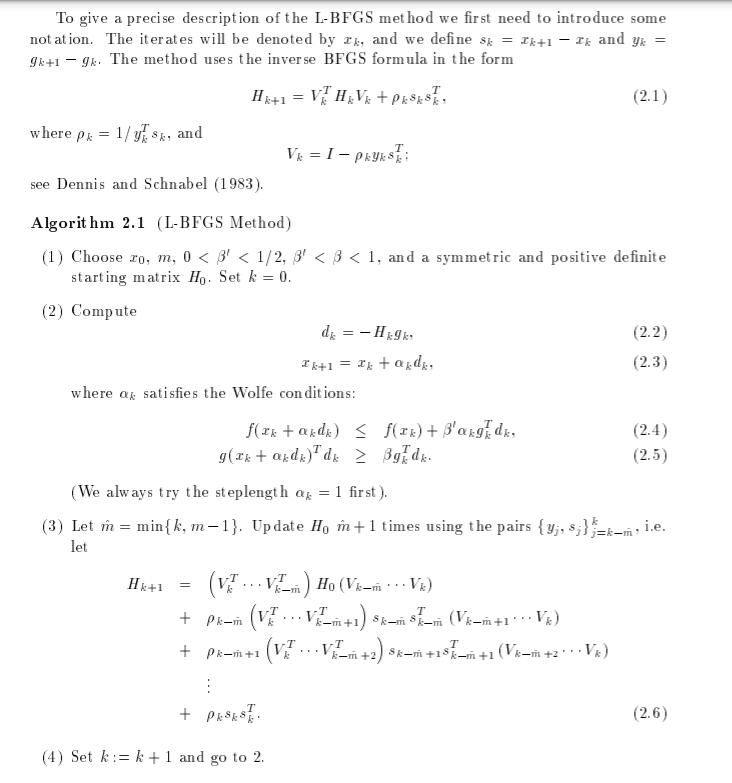

In [ ]:
Image('/content/20210416223229.jpg')

**As from above, to compute H(k+1), we only need to store H(0)--identity matrix and (s(k),y(k))--V & p is computed by s & y.**



In [ ]:
def update_LBFGS(ys,ss,m,k):  # too slow and resource consumed, unused
  I_matrix = torch.eye(4000,dtype=torch.double).to(device)
  if m >= k:
    Vs = []
    ps = []
    for i in range(k):
      ps.append(torch.divide(torch.tensor(1,dtype=torch.double).to(device),torch.dot(ys[i].T,ss[i])))
      Vs.append(torch.subtract(I_matrix,torch.mul(ps[i],torch.tensordot(ys[i],ss[i],dims=0))))
    if k == 1:
      return torch.tensordot(Vs[0].T,Vs[0],dims=1)
    
    res = torch.mul(ps[i],torch.tensordot(ss[k-1],ss[k-1],dims=0))
    for i in range(k-1,-1,-1): 
      if i == k-1:
        V_left = Vs[i].T
        V_right = Vs[i]
      else:
        V_left = torch.tensordot(V_left,Vs[i].T,dims=1)
        V_right = torch.tensordot(V_right,Vs[i],dims=1)
      if i == 0:
        res += torch.tensordot(V_left,V_right,dims=1)
      else:
        res += torch.mul(ps[i],torch.tensordot(torch.tensordot(torch.tensordot(V_left,ss[i-1],dims=1),ss[i-1].T,dims=0),V_right,dims=1))
        

  else:
    Vs = []
    ps = []
    for i in range(m):
      ps.append(torch.divide(torch.tensor(1,dtype=torch.double).to(device),torch.dot(ys[i].T,ss[i])))
      Vs.append(torch.subtract(I_matrix,torch.mul(ps[i],torch.tensordot(ys[i],ss[i],dims=0))))
    #print(max(ps))
    if m == 1:
      return torch.tensordot(Vs[0].T,Vs[0],dims=1)
    
    res = torch.mul(ps[i],torch.tensordot(ss[m-1],ss[m-1],dims=0))
    for i in range(m-1,-1,-1): 
      if i == m-1:
        V_left = Vs[i].T
        V_right = Vs[i]
      else:
        V_left = torch.tensordot(V_left,Vs[i].T,dims=1)
        V_right = torch.tensordot(V_right,Vs[i],dims=1)
      if i == 0:
        res += torch.tensordot(V_left,V_right,dims=1)
      else:
        res += torch.mul(ps[i],torch.tensordot(torch.tensordot(torch.tensordot(V_left,ss[i-1],dims=1),ss[i-1].T,dims=0),V_right,dims=1))
  return res

**The above code to compute H is very time and memory consuming, Therefore, we can use the following code which compute g*H instead.**

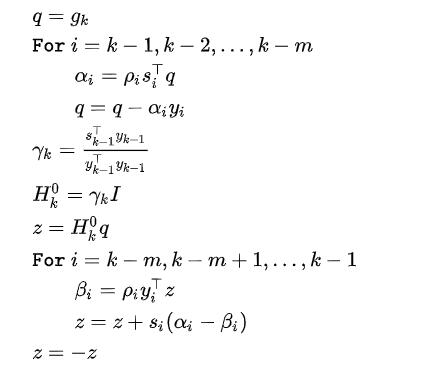

In [ ]:
Image('/content/20210417024114.jpg')

In [ ]:
def update_H_LBFGS(gd,ys,ss,m,k):
  q = gd
  m = min(m,k)
  ps = []
  alphas = []
  for i in range(m):
    ps.append(torch.divide(torch.tensor(1,dtype=torch.double).to(device),torch.dot(ys[i].T,ss[i])))
  
  for i in range(m-2,-1,-1):
    #print(ps[k-1-i])
    #print(ss[i])
    #print(gd)
    #print(ps[k-1-i]*ss[i].T)
    alphas.append(torch.dot((ps[i]*ss[i].T),q))
    q -= torch.mul(alphas[m-2-i],ys[i])
    
  z = q
  
  for i in range(0,m-1):
    beta = torch.mul(ps[i],torch.dot(ys[i],z)) 
    z = z + torch.mul(ss[i],(alphas[m-2-i]-beta))
    
  return z

In [ ]:
def train_LBFGS(X,y,X_test,y_test,i,w,lam,ep,lr,m):
  e = 1
  total_iter = 0
  ys = [torch.zeros(len(X),dtype=torch.double).to(device) for i in range(m)]
  ss = [torch.zeros(len(X),dtype=torch.double).to(device) for i in range(m)]

  while e > ep and total_iter < 10000:
    for j in range(1): # used for mini-batches, while seems unsufficient, unused
      if total_iter == 0:
        H = torch.eye(len(X),dtype=torch.double).to(device)
        g_old = torch.zeros(len(X)).to(device)
      else:
        g_old = g
      w_old = w
      g = Gradient2(X,y,w,lam)
      if total_iter >= 1:
        g = update_H_LBFGS(g,ys,ss,m,total_iter+1)
      g = torch.divide(g,(total_iter+1)**0.5)
      w = torch.subtract(w,torch.multiply(lr,g))
      e = torch.median((abs(g)))


      if total_iter < m:
        ys[total_iter] = g - g_old
        ss[total_iter] = w - w_old
      else:
        ys = ys[1:]
        ss = ss[1:]
        ys.append(g - g_old)
        ss.append(w - w_old)

    total_iter += 1
    loss_his_LBFGS[i].append(Loss(X_test,y_test,w,lam))
    if total_iter%1000 == 0:
      print("iter: " + str(total_iter) + 
            "    gradient median: " + str(e.item()) +
            "    loss: " + str(loss_his_LBFGS[i][-1].item())
            )
      eval(X,y,w)
  eval(X,y,w)
  return w

In [ ]:
%%time
loss_his_LBFGS = [[] for i in range(20)]
w_trained_LBFGS = []
w = initial_weight(4000)

m = 1
for i in range(0,5):
  print("lr = " + str(lrs[i]) + " :")
  w = initial_weight(4000)
  w_trained_LBFGS.append(train_LBFGS(KX_trans,y_trans_shuffle,KX_trans,y_trans_shuffle,i,w,lam,1e-5,lrs[i],m))

m = 2
for i in range(0,5):
  print("lr = " + str(lrs[i]) + " :")
  w = initial_weight(4000)
  w_trained_LBFGS.append(train_LBFGS(KX_trans,y_trans_shuffle,KX_trans,y_trans_shuffle,i+5,w,lam,1e-5,lrs[i],m))

m = 5
for i in range(0,5):
  print("lr = " + str(lrs[i]) + " :")
  w = initial_weight(4000)
  w_trained_LBFGS.append(train_LBFGS(KX_trans,y_trans_shuffle,KX_trans,y_trans_shuffle,i+10,w,lam,1e-5,lrs[i],m))

m = 10
for i in range(0,5):
  print("lr = " + str(lrs[i]) + " :")
  w = initial_weight(4000)
  w_trained_LBFGS.append(train_LBFGS(KX_trans,y_trans_shuffle,KX_trans,y_trans_shuffle,i+15,w,lam,1e-5,lrs[i],m))


lr = tensor(0.1000) :
iter: 1000    gradient median: 3.1496670474384856    loss: 21.829592030965213
acc is: 87.05%
iter: 2000    gradient median: 2.226437106798734    loss: 11.167954871104131
acc is: 51.6%
iter: 3000    gradient median: 1.574673043333596    loss: 8.442878319796277
acc is: 62.075%
iter: 4000    gradient median: 1.8663055979277656    loss: 9.997104897469764
acc is: 50.0%
iter: 5000    gradient median: 1.3793118291611663    loss: 6.614562978790898
acc is: 75.25%
iter: 6000    gradient median: 1.066244329195008    loss: 5.827623970797886
acc is: 61.95%
iter: 7000    gradient median: 1.3764162740806156    loss: 10.592783122164333
acc is: 50.0%
iter: 8000    gradient median: 1.0873319735830942    loss: 4.905862954125409
acc is: 80.05%
iter: 9000    gradient median: 1.0497274043882554    loss: 5.912688307010953
acc is: 58.675%
iter: 10000    gradient median: 0.9959020635978619    loss: 6.118870557224923
acc is: 50.0%
acc is: 50.0%
lr = tensor(0.0100) :
iter: 1000    gradient 

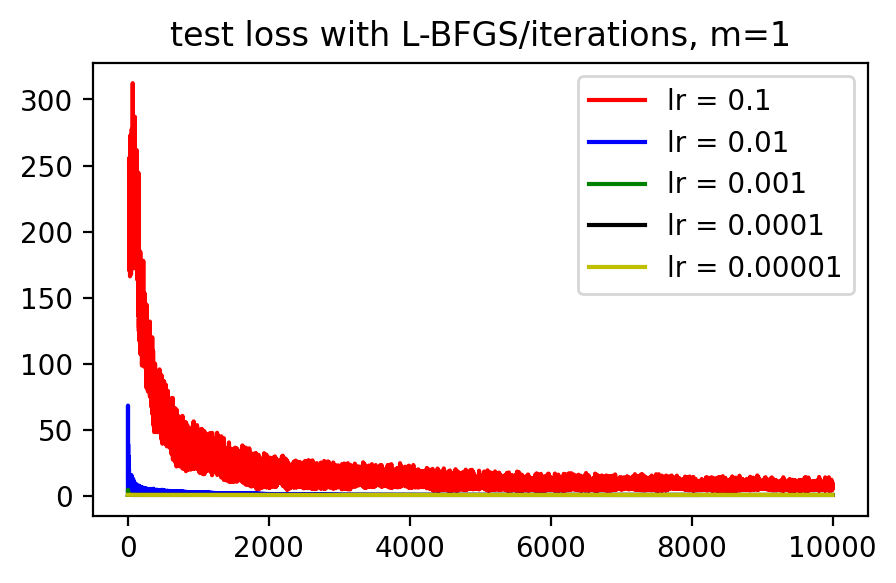

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with L-BFGS/iterations, m=1')
plt.plot(loss_his_LBFGS[0], 'r', label='lr = 0.1')
plt.plot(loss_his_LBFGS[1], 'b', label='lr = 0.01')
plt.plot(loss_his_LBFGS[2], 'g', label='lr = 0.001')
plt.plot(loss_his_LBFGS[3], 'k', label='lr = 0.0001')
plt.plot(loss_his_LBFGS[4], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

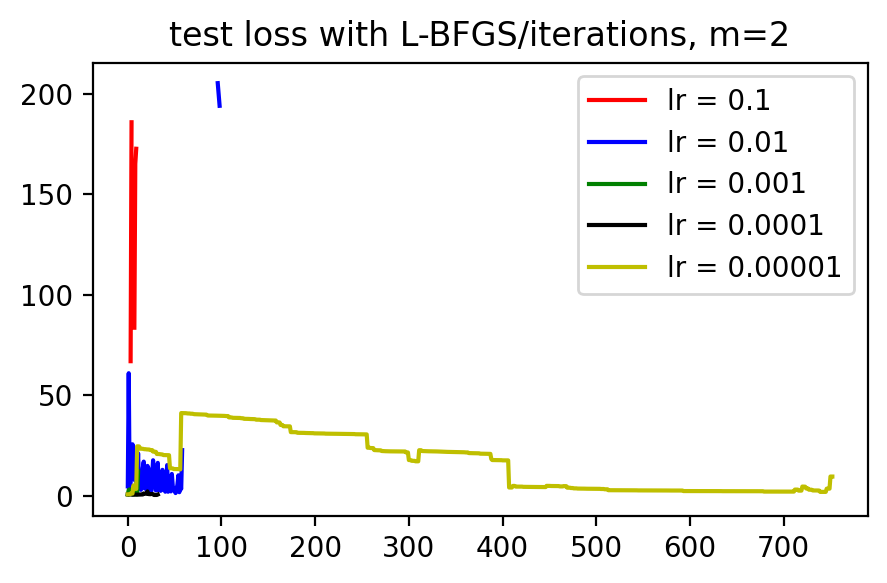

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with L-BFGS/iterations, m=2')
plt.plot(loss_his_LBFGS[5], 'r', label='lr = 0.1')
plt.plot(loss_his_LBFGS[6], 'b', label='lr = 0.01')
plt.plot(loss_his_LBFGS[7], 'g', label='lr = 0.001')
plt.plot(loss_his_LBFGS[8], 'k', label='lr = 0.0001')
plt.plot(loss_his_LBFGS[9], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

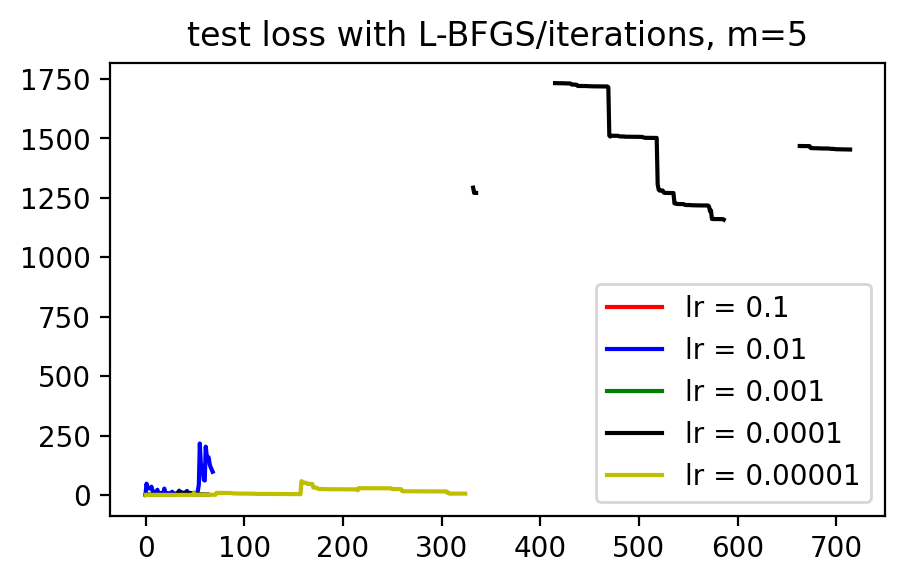

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with L-BFGS/iterations, m=5')
plt.plot(loss_his_LBFGS[10], 'r', label='lr = 0.1')
plt.plot(loss_his_LBFGS[11], 'b', label='lr = 0.01')
plt.plot(loss_his_LBFGS[12], 'g', label='lr = 0.001')
plt.plot(loss_his_LBFGS[13], 'k', label='lr = 0.0001')
plt.plot(loss_his_LBFGS[14], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

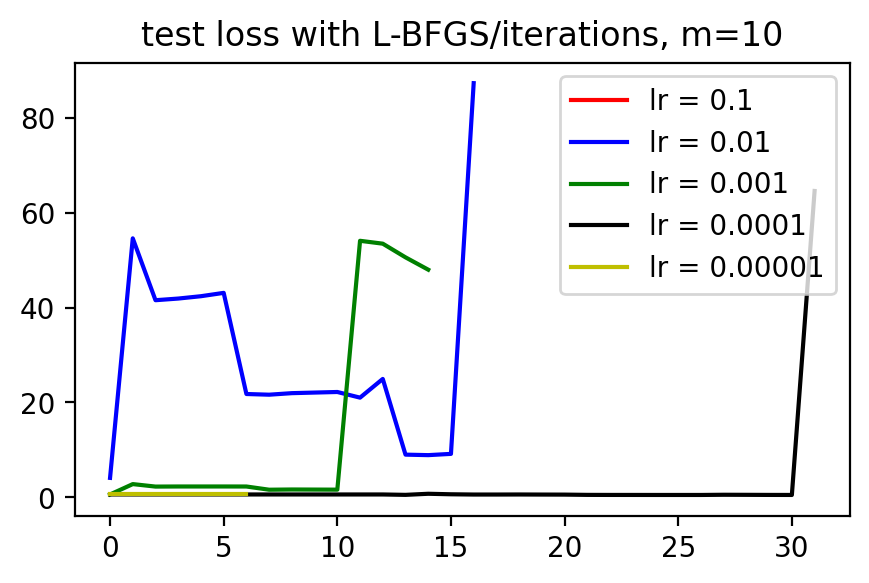

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.title('test loss with L-BFGS/iterations, m=10')
plt.plot(loss_his_LBFGS[15], 'r', label='lr = 0.1')
plt.plot(loss_his_LBFGS[16], 'b', label='lr = 0.01')
plt.plot(loss_his_LBFGS[17], 'g', label='lr = 0.001')
plt.plot(loss_his_LBFGS[18], 'k', label='lr = 0.0001')
plt.plot(loss_his_LBFGS[19], 'y', label='lr = 0.00001')
plt.legend()
plt.show()

**with small m, the L-BFGS trains fast and attain a high accuracy.with learning rate = 0.01, m=1 89.225%, m=2, 81.6% (shown above in the ouput of the training process)**

**when m becomes large(5~10). The model might be affected by the presvious abnormal gradient. Theredor it becomes unstable**